In [1]:
import StepPotential as sp

import sympy as sym

import matplotlib.pyplot as plt

import numpy as np
from ipywidgets import interact

In [2]:
sym.init_printing()

In [3]:
%matplotlib notebook

# Single step with free boundary conditions

Get symbolic variables used by the code:

In [4]:
dV, f0 = sp.w, sp.f0

In [5]:
x_init = sym.symbols("x_i",negative=True)

In case of a singe step at $x_\text{init} = 0$ the virtual initial distributions correspond to the real initial distributions in the following way:
* $q_1(x) = p(x,t=0) = \delta(x-x_{\text{init}})$ for $x<0$
* $q_2(x) = p(x,t=0) = 0$ for $x>0$

The implementation expects the virtual distributions in their rescaled form $g_i(x) = e^{-f_0*x/2} q_i(x)$
We provide the functions using the ``PiecewisePolyExp`` class.

In [6]:
left = sp.PiecewisePolyExp(jumpPos=x_init,delta_prefac=sym.exp(-f0*x_init/2))
left

exp(-f*x_i/2)*DiracDelta(x - x_i)

For the right half axis the virtual initial distributio is zero. ``PiecewisePolyExp`` allways needs a ``jumpPos`` argument, so we set it to $-x_\text{init}$, i.e., the mirror position of the actual peak and set the ``delta_prefac`` to zero.

In [7]:
right =sp.PiecewisePolyExp(-x_init,delta_prefac=0)
right

0

The reflection operators $\hat{S}_i^\pm$ are implemented in ``mirrorRight`` and ``mirrorLeft``, respectively.

In [8]:
res1 = sp.mirrorRight(fl=left, fr=right,w=dV,f0=f0,xlp=0,xr=0,x0=0,fl_start=0)

Combined with the known part on the negative half axis ``left``, this result curresponds to eq. (28) in the paper before the rescaling is reversed.

In [9]:
res1 + left

(f*exp(-f*x_i/2)*exp(f*x_i*tanh(w/2)/2)*tanh(w/2)**2/2 + f*exp(-f*x_i/2)*exp(f*x_i*tanh(w/2)/2)*tanh(w/2)/2)*exp(f*x*tanh(w/2)/2)*Heaviside(x + x_i) + exp(-f*x_i/2)*tanh(w/2)*DiracDelta(x + x_i) + exp(-f*x_i/2)*DiracDelta(x - x_i)

The time-evolution can be calculated from the rescaled virtual initial distribution using the ``time_evolution`` function. The result is eq. (30)

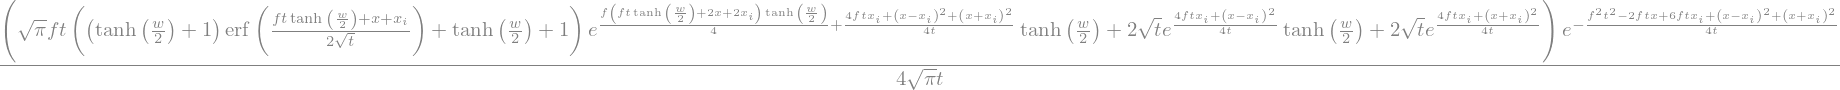

In [10]:
p1 = sym.simplify(sp.time_evolution(res1 + left))
p1

In the same way we can calculate the virtual initial distribution for the positive half-axis using ``mirrorLeft``, i.e., eq. (29)

/usr/lib/python3.8/site-packages/sympy/core/sympify.py:383: SymPyDeprecationWarning: 

String fallback in sympify has been deprecated since SymPy 1.6. Use
sympify(str(obj)) or sympy.core.sympify.converter or obj._sympy_
instead. See https://github.com/sympy/sympy/issues/18066 for more
info.

  SymPyDeprecationWarning(


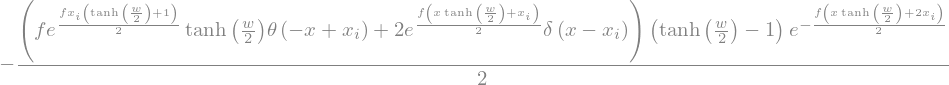

In [11]:
res2 = sp.mirrorLeft(left,right,dV,f0,0,0,0,0)
sym.simplify(res2)

In [12]:
p2= sym.simplify(sp.time_evolution(res2))

Unfortunately, sympy simplifications can only be applied in the last step when no further manipulations are needed.Therefore, the results can become needlessly convoluted. This does not hinder us from evaluating them when plotting.

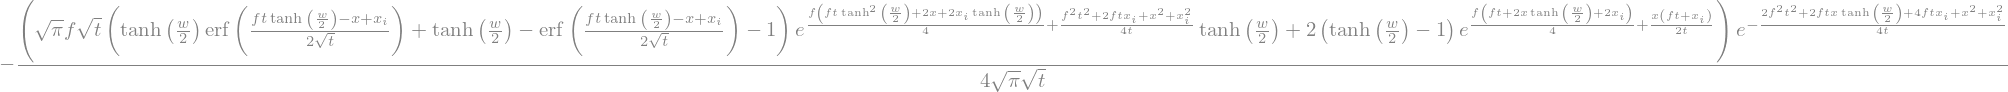

In [13]:
p2 = p2.expand().simplify()
p2

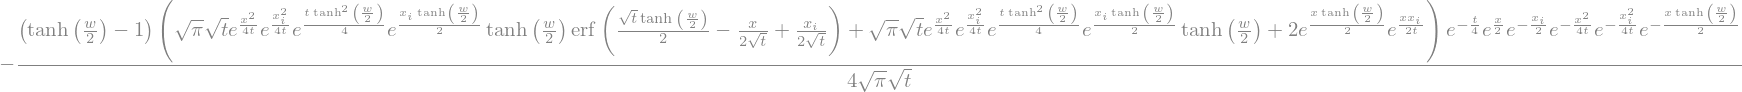

In [14]:
sym.simplify(p2.subs(f0,1)).factor()

It follows the code used to create figure 2:

In [15]:
from StepPotential import t,w,x
import matplotlib.patheffects as path_effects

f_num =2
w_num = 1
N = 5000

num_lw=2.2
pe = [path_effects.Stroke(linewidth=1.5,foreground="black"),path_effects.Normal()]

fl = sp.PiecewisePolyExp(-2,delta_prefac=np.exp(2))
fr = sp.PiecewisePolyExp(2,delta_prefac=0)
fl2 = sp.mirrorRight(fl,fr, w=w_num,f0=f_num,xlp=0,xr=0,x0=0,fl_start=0)

fr2 = sp.mirrorLeft(fl, fr, w=w_num, f0=f_num, xlp=0, xr=0,x0=0, fr_start=0)

te = sp.time_evolution(fl,upper=0).simplify()
te2 = sp.time_evolution(fl2,lower=0).simplify()
te3 = sp.time_evolution(fr2,upper=0).simplify()

def plotpart(ax,t_num):
    # plot potential step
    light1 = "#00A9FA"
    light2 = "#6BDEFF"
    ax.fill_between([0,10],[0,0],[0.1,0.1], facecolor=light1)
    ax.plot([-10,0,0,10],[0,0,0.1,0.1],color=light2)

    p1_ana= te.subs([(f0,f_num),
                    (t,t_num)
                   ])
    p2_ana= te2.subs([(f0,f_num),
                    (t,t_num),
                      (w,w_num)
                   ])
    p3_ana= te3.subs([(f0,f_num),
                    (t,t_num),
                      (w,w_num)
                   ])

    plotfun1 = sym.lambdify(x, p1_ana)
    plotfun2 = sym.lambdify(x, p2_ana)
    plotfun3 = sym.lambdify(x, p3_ana)


    x_range = np.linspace(-10,10,1000)
    x_range_num = np.linspace(-10,10,N)
    x_neg = np.linspace(-10,0,500)
    x_pos = np.linspace(0,10,500)
    ax.margins(0,2)
    ax.plot(x_range,plotfun1(x_range),color="C3",ls=":",label="without step")
    ax.plot(x_neg,(plotfun1(x_neg)+plotfun2(x_neg)),color="C1",label="$p(x<0,t)$",path_effects=pe)
    ax.plot(x_pos,(plotfun1(x_pos)+plotfun2(x_pos)),ls="--", color="C1")

    ax.plot(x_pos,(plotfun3(x_pos)),color="C2",label="$p(x>0,t)$",path_effects=pe)
    ax.plot(x_neg,(plotfun3(x_neg)),ls="--",color="C2")

    
    ax.set_ylim((-0.05,0.7))
    ax.set_yticks(np.arange(0,0.7,0.1))
    ax.text(0.05, 0.90, "t={0:.2f}".format(t_num),
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes)
    ax.set_ylabel("$p(x,t)$")


<IPython.core.display.Javascript object>


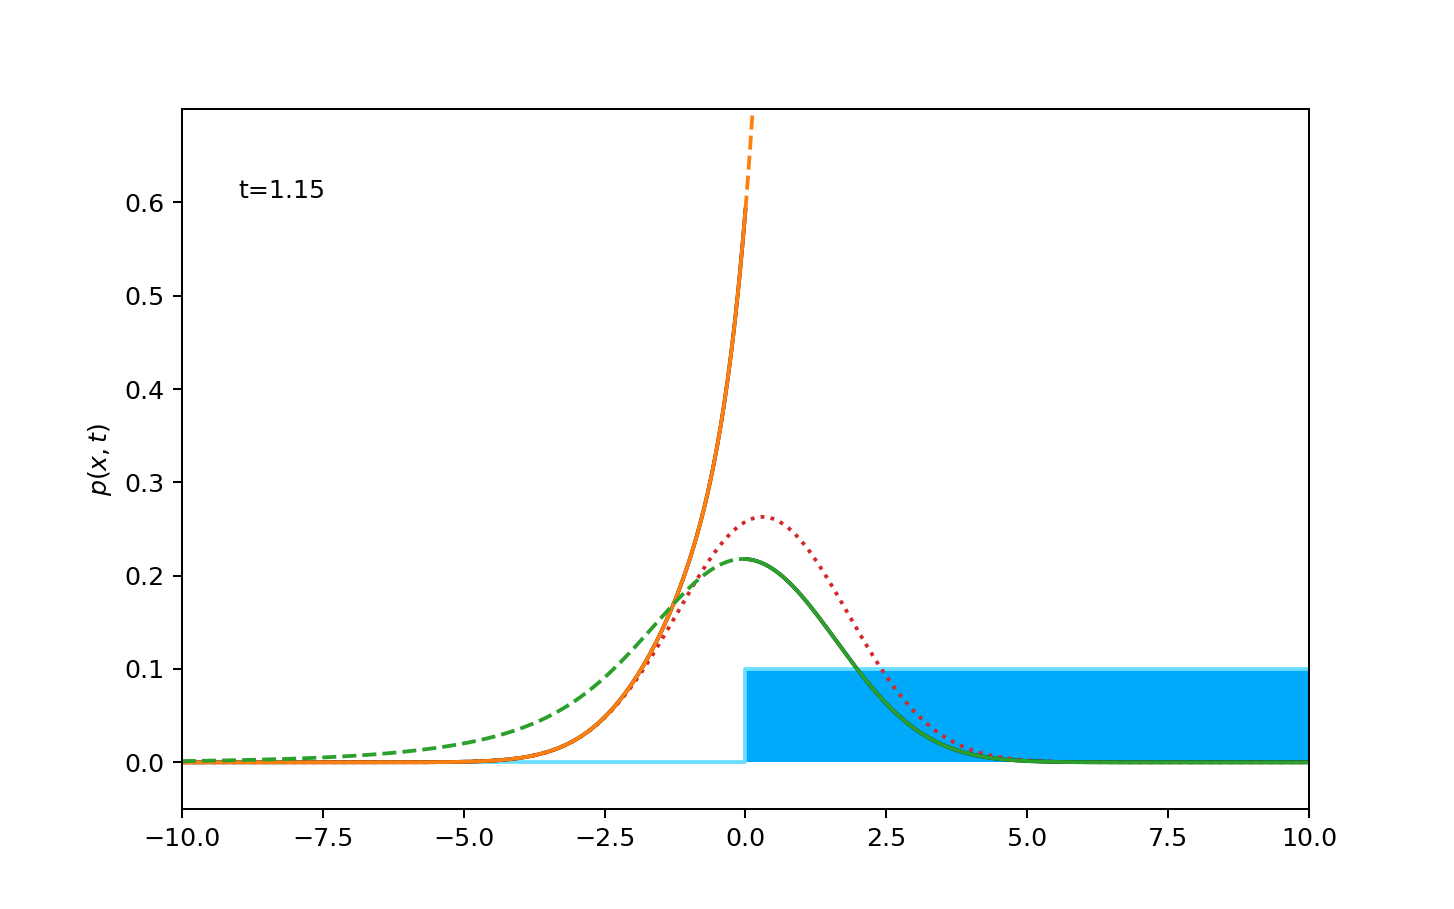

In [16]:
plt.figure(figsize=(8,5))
ax1 = plt.gca()
plotpart(ax1,1.4)
plt.show()

In [17]:
@interact(t_num=(0.001,5.,0.01))
def interactive_plot(t_num=1.4):
    ax1.clear()
    plotpart(ax1, t_num)

interactive(children=(FloatSlider(value=1.4, description='t_num', max=5.0, min=0.001, step=0.01), Output()), _…

# Double step with free boundary conditions

For systems with more than one potential step, the reflection operators have to be applied multiple times. For the double step case, this method is implemented in the ``double_step_evolution_approx`` function. It expects the positions and heights of the potential steps as well as the initial position and the number of reflections to be performed.

For the paramters used in figure 5, the results after two reflections without the extension of the interval of validity of the outermost known parts of the virtual initial distribution, the results are

In [18]:
p1, p2, p3 = sp.double_step_evolution_approx(2,1,-1,-2,2,2,-5,simplify=True, numerical_result=False)

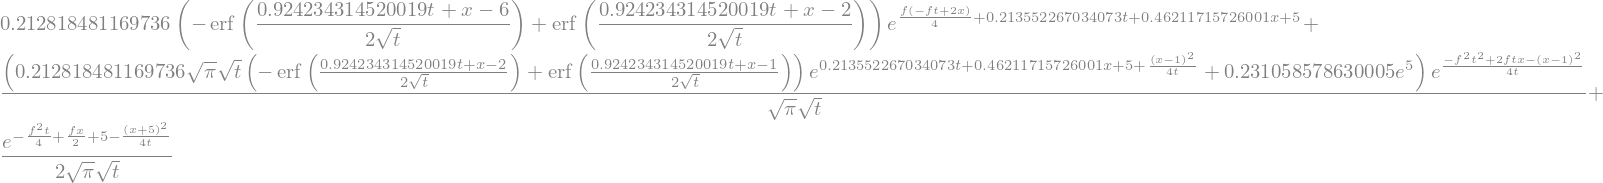

In [19]:
p1

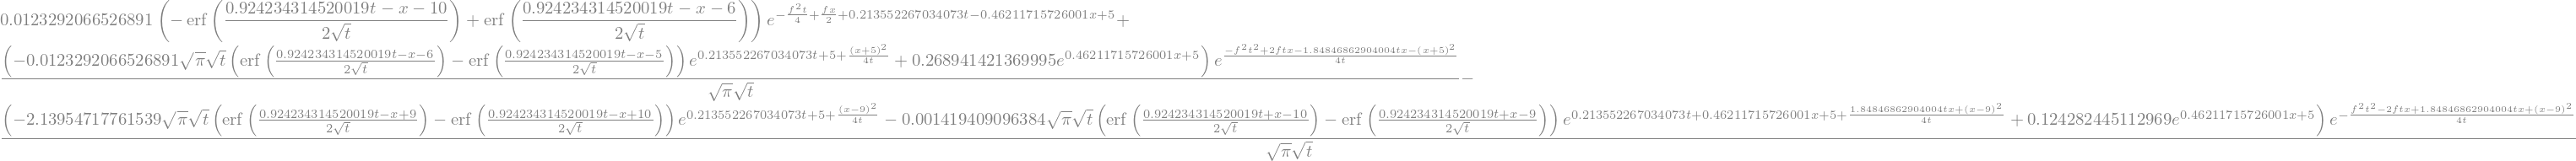

In [20]:
p2

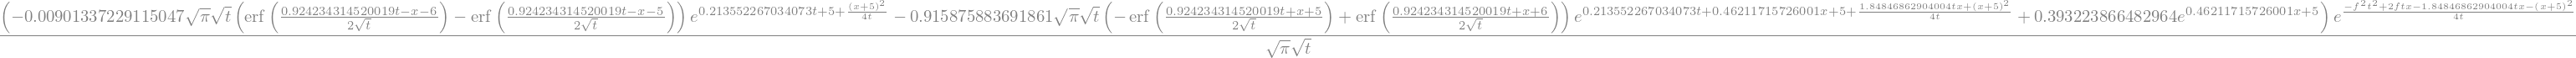

In [21]:
p3

As discussed in the paper, the result gets better if one extends the outer known parts of the virtual initial distributions to infinity. Unfortunately sympy does not seem to be able to calculate the limits involved with these infinities, so we have to use large but finite values instead. We cann suply the boundaries of the extension interval as an additional argument to the function.

In [22]:
p1_e, p2_e, p3_e = sp.double_step_evolution_approx(2,1,-1,-2,2,2,-5,simplify=False,extended_range=(-50,50))

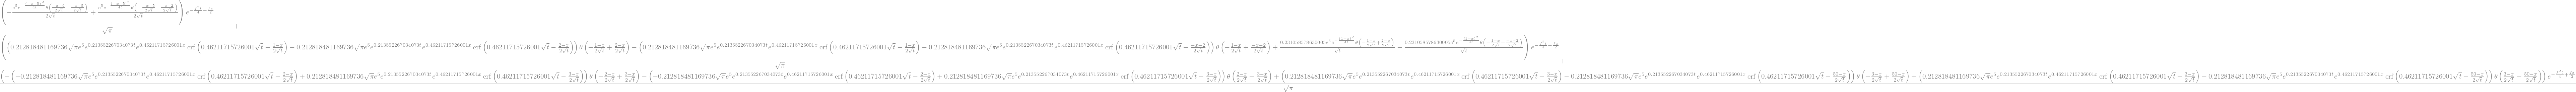

In [23]:
p1_e

For convenience, one can instruct the function to return python functions that can directly be used for numerical evaluation of the results, which we use to reproduce the plot shown as figure 5 in the paper.

<IPython.core.display.Javascript object>


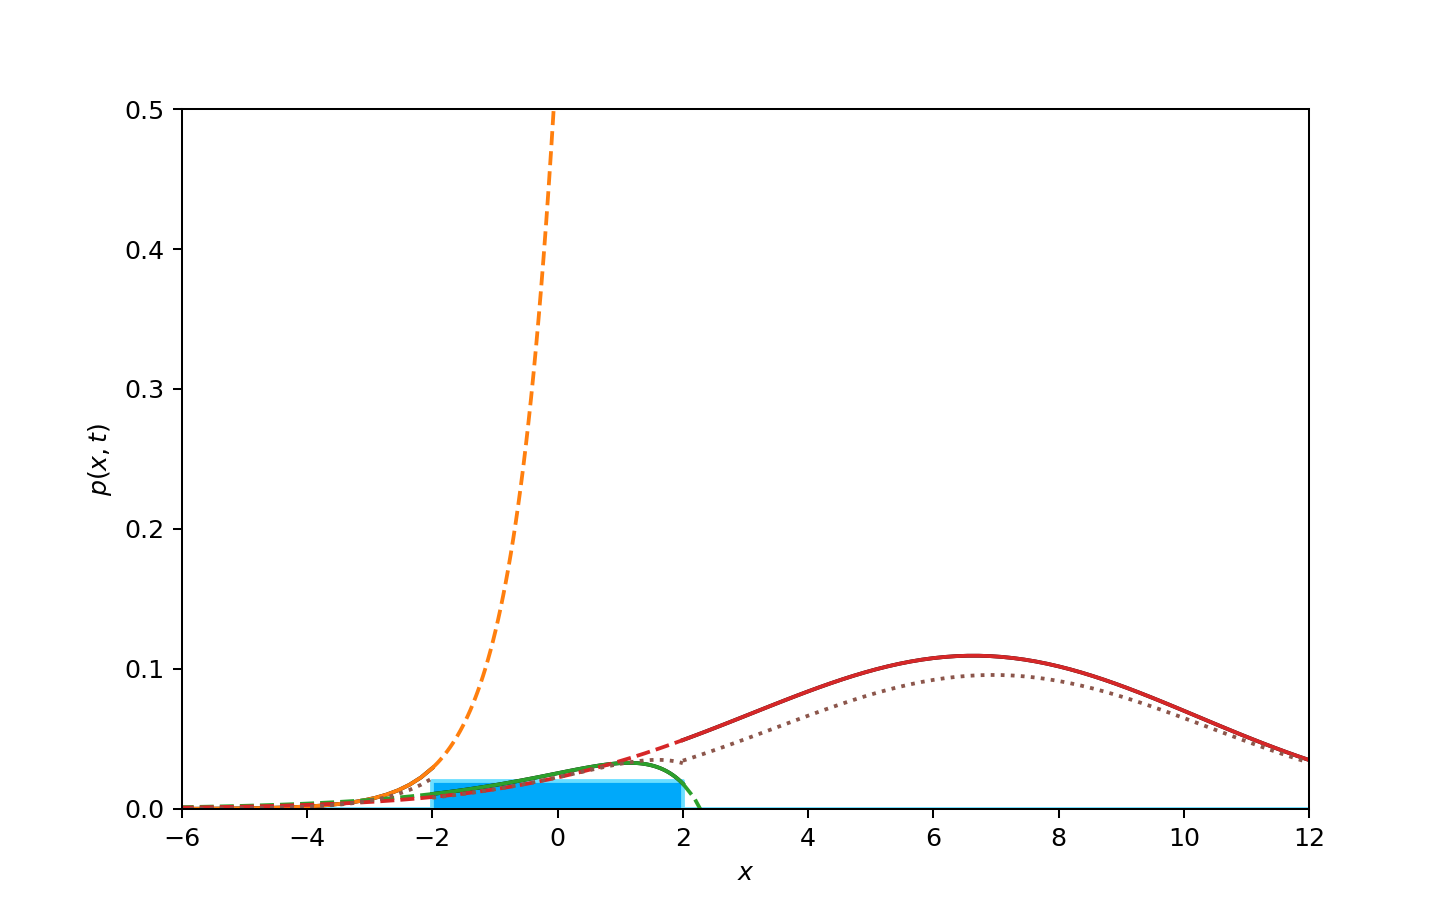

In [24]:
N = 5000
xmax = 20
x0 = -5
x_range = np.linspace(-xmax,xmax,N)

x_range_left = np.linspace(-20,-2,100)
x_range_mid = np.linspace(-2,2,100)
x_range_right = np.linspace(2,20,100)
x_range_left_inv = np.hstack((x_range_mid,x_range_right))
x_range_right_inv = np.hstack((x_range_left,x_range_mid))

num_lw=2.2
pe = [path_effects.Stroke(linewidth=1.5,foreground="black"),path_effects.Normal()]

plotfun1, plotfun2, plotfun3 = sp.double_step_evolution_approx(2,1,-1,-2,2,2,-5,simplify=False, numerical_result=True,extended_range=(-50,50))
plotfun1_s, plotfun2_s, plotfun3_s = sp.double_step_evolution_approx(2,1,-1,-2,2,2,-5,simplify=False, numerical_result=True)



def makePlot(ax, t_num):
    # plot potential step
    light1 = "#00A9FA"
    light2 = "#6BDEFF"
    ax.fill_between([-2,2],[0,0],[0.02,0.02], facecolor=light1)
    ax.plot([-6,-2,-2,2,2,12],[0,0,0.02,0.02,0,0],color=light2)

    ax.plot(x_range_left,plotfun1(x_range_left, t_num),color="C1",label="$p(x<-2, t)$",
             path_effects=pe)
    ax.plot(x_range_left_inv,plotfun1(x_range_left_inv, t_num),color="C1",ls="--")
    ax.plot(x_range_mid,plotfun2(x_range_mid, t_num),color="C2",label="$p(-2<x<2, t)$",
             path_effects=pe)
    ax.plot(x_range_left,plotfun2(x_range_left, t_num),color="C2",ls="--")
    ax.plot(x_range_right,plotfun2(x_range_right, t_num),color="C2",ls="--")
    ax.plot(x_range_right,plotfun3(x_range_right, t_num),color="C3",label="$p(2<x, t)$",
             path_effects=pe)
    ax.plot(x_range_right_inv,plotfun3(x_range_right_inv, t_num),color="C3",ls="--")

    ax.plot(x_range_left,plotfun1_s(x_range_left, t_num),color="C5",ls=":",label="without extension",)
    ax.plot(x_range_mid,plotfun2_s(x_range_mid, t_num),color="C5",ls=":")
    ax.plot(x_range_right,plotfun3_s(x_range_right, t_num),color="C5",ls=":")
    ax.set_xlim((-6,12))
    ax.set_ylim((0,0.5))
    ax.set_ylabel("$p(x, t)$")
    ax.set_xlabel("$x$")

plt.figure(figsize=(8,5))
ax2=plt.gca()
plt.show()


In [25]:
@interact(t_num=(0.001,10.,0.01))
def interactive_plot(t_num=4.5):
    ax2.clear()
    makePlot(ax2, t_num)

interactive(children=(FloatSlider(value=4.5, description='t_num', max=10.0, min=0.001, step=0.01), Output()), …

# Periodic boundary conditions

The periodic step encountered in the Brownian ratchet model is implemented in the function ``periodic_step_evolution_approx`` that functions in the same way as the counterpart for the two step case.

<IPython.core.display.Javascript object>


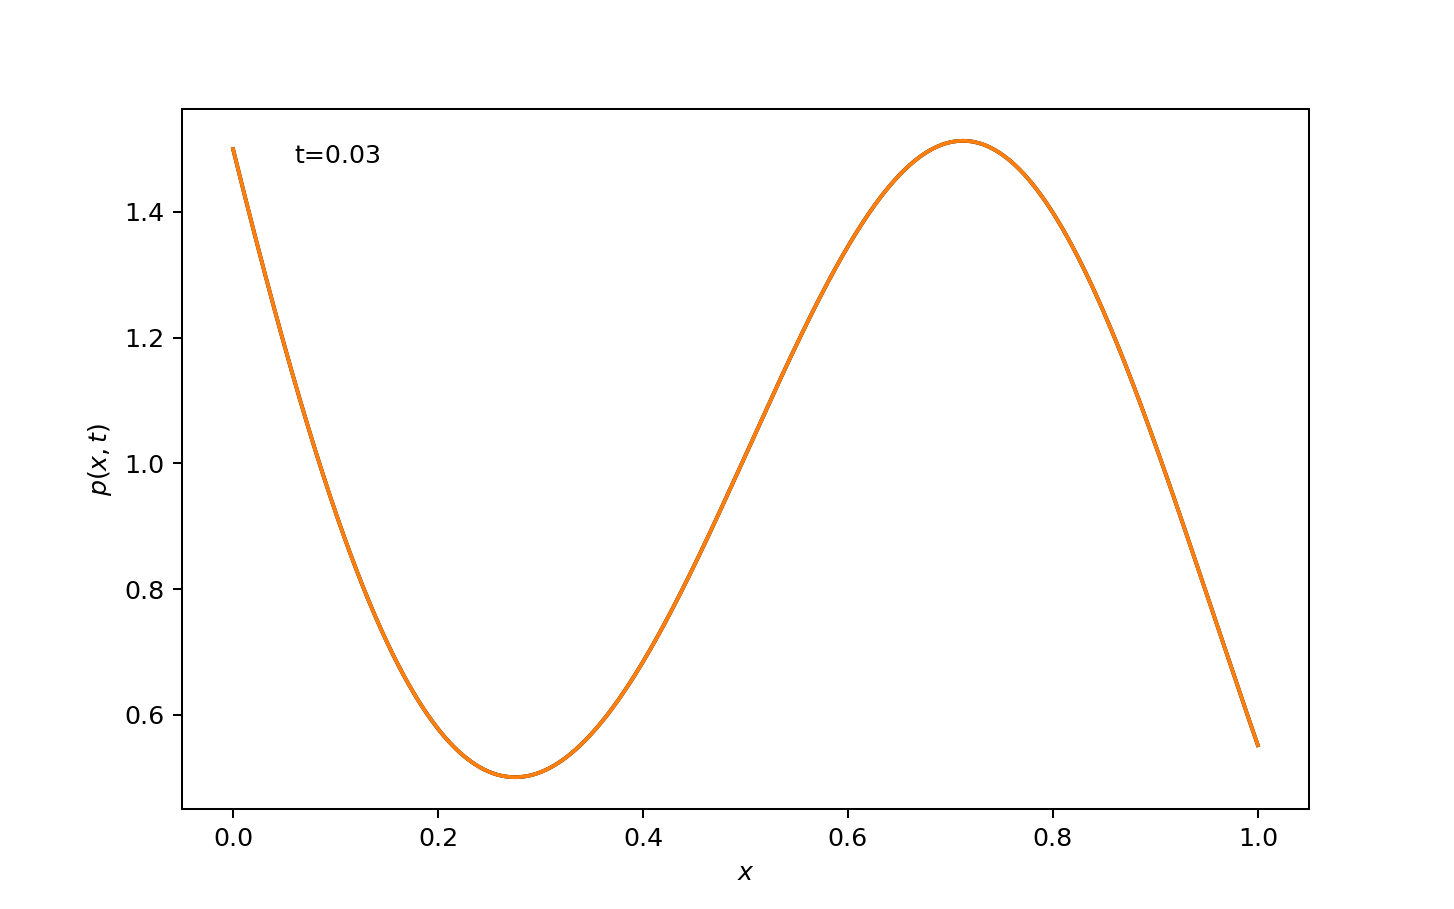

In [26]:
N = 1000
xp = 1
f0_per=-2
w_per=-1
x0 = 0.8
x_range_3 = np.linspace(0,xp,N)


te_num1 = sp.periodic_step_evolution_approx(f0_per,w_per,xp,2,x0,simplify=False, numerical_result=True, extended_range=(-50,50))

num_lw=2.2
pe = [path_effects.Stroke(linewidth=1.5,foreground="black"),path_effects.Normal()]

def plot_periodic(ax, t_num, ylim=None):
    ax.plot(x_range_3,te_num1(x_range_3,t_num),color="C1", label=r"mirror approxmation",
           path_effects=pe)
    ax.set_ylim(ylim)
    ax.text(0.1, 0.95, "t={0:.2f}".format(t_num),
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$p(x,t)$")

plt.figure(figsize=(8,5))
ax3 = plt.gca()
plot_periodic(ax3,1)
plt.show()



In [27]:
@interact(t_num=(0.0001,.1,0.01))
def interactive_plot(t_num=0.05):
    ax3.clear()
    plot_periodic(ax3,t_num)

interactive(children=(FloatSlider(value=0.05, description='t_num', max=0.1, min=0.0001, step=0.01), Output()),…